In [2]:
# !pip install tensorflow==1.15.0

In [3]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

In [4]:
randomState = 42
np.random.seed(randomState)
tf.set_random_seed(randomState)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Depth 5cm

In [6]:
raw5 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_5.csv')
df5 = raw5.copy()

df5 = df5.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df5['NDVI'])
replace_missing(df5['EVI'])
replace_missing(df5['LSTDay'])
replace_missing(df5['LSTNight'])

df5 = df5.dropna()
df5.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [7]:
df5['group'] = df5['Sand'].ne(df5['Sand'].shift()).cumsum()
df5 = df5.groupby('group')
dfs = []
for name, data in df5:
    dfs.append(data)

In [8]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [9]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [10]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

validation_data = (x_val, y_val)

In [11]:
opt_par = [0.009952590905472028, 4, 131, 'sigmoid']

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 131)               1834      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 131)               17292     
_________________________________________________________________
layer_dense_3 (Dense)        (None, 131)               17292     
_________________________________________________________________
layer_dense_4 (Dense)        (None, 131)               17292     
_________________________________________________________________
dense (Dense)                (None, 1)                 132       
Total params: 53,842
Trainable params: 53,842
Non-trainable params: 0
_________________________________________________________________
Train on 43975 samples, validate on 5

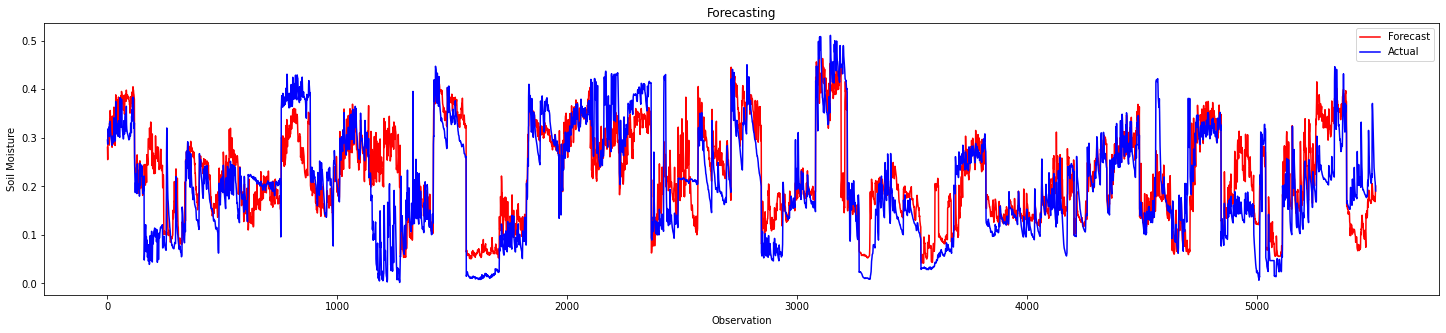

In [12]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/DNN_c5_5.png', dpi=400)
plt.show()

#Depth 10cm

In [13]:
raw10 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_10.csv')
df10 = raw10.copy()

df10 = df10.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df10['NDVI'])
replace_missing(df10['EVI'])
replace_missing(df10['LSTDay'])
replace_missing(df10['LSTNight'])

df10 = df10.dropna()
df10.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [14]:
df10['group'] = df10['Sand'].ne(df10['Sand'].shift()).cumsum()
df10 = df10.groupby('group')
dfs = []
for name, data in df10:
    dfs.append(data)

In [15]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [16]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [17]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

validation_data = (x_val, y_val)

In [18]:
opt_par = [0.009748955930349731, 4, 130, 'sigmoid']

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 130)               1820      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 130)               17030     
_________________________________________________________________
layer_dense_3 (Dense)        (None, 130)               17030     
_________________________________________________________________
layer_dense_4 (Dense)        (None, 130)               17030     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 131       
Total params: 53,041
Trainable params: 53,041
Non-trainable params: 0
_________________________________________________________________
Train on 43097 samples, validate on 5383 samples
Epoch 1/100
43097/43097 - 3s - loss: 0.0175 - mean_squared_error: 0

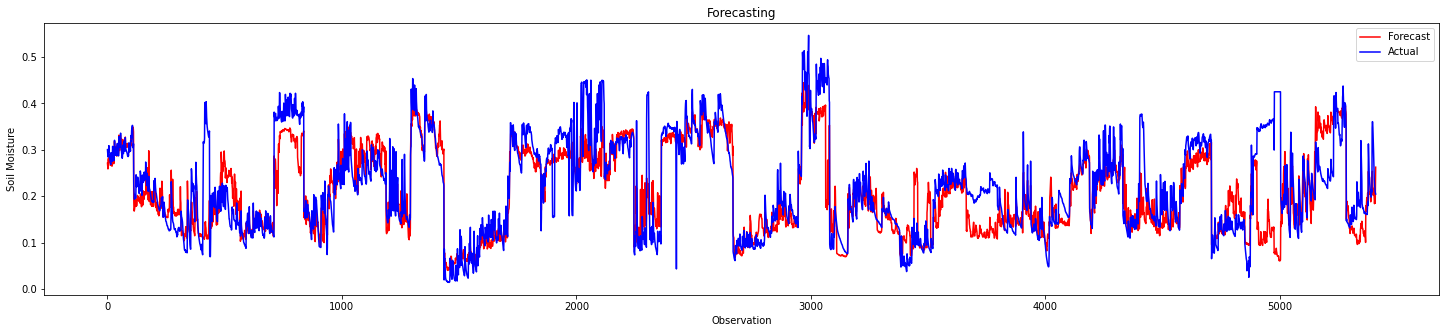

In [19]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/DNN_c5_10.png', dpi=400)
plt.show()

#Depth 20cm

In [20]:
raw20 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_20.csv')
df20 = raw20.copy()

df20 = df20.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df20['NDVI'])
replace_missing(df20['EVI'])
replace_missing(df20['LSTDay'])
replace_missing(df20['LSTNight'])

df20 = df20.dropna()
df20.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [21]:
df20['group'] = df20['Sand'].ne(df20['Sand'].shift()).cumsum()
df20 = df20.groupby('group')
dfs = []
for name, data in df20:
    dfs.append(data)

In [22]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [23]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [24]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

validation_data = (x_val, y_val)

In [25]:
opt_par = [0.00837268150852779, 2, 131, 'relu']

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 131)               1834      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 131)               17292     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 132       
Total params: 19,258
Trainable params: 19,258
Non-trainable params: 0
_________________________________________________________________
Train on 39353 samples, validate on 4918 samples
Epoch 1/100
39353/39353 - 3s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/100
39353/39353 - 3s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/100
39353/39353 - 3s - loss: 0.0019 - mean_squared_error: 0.0019 - val_lo

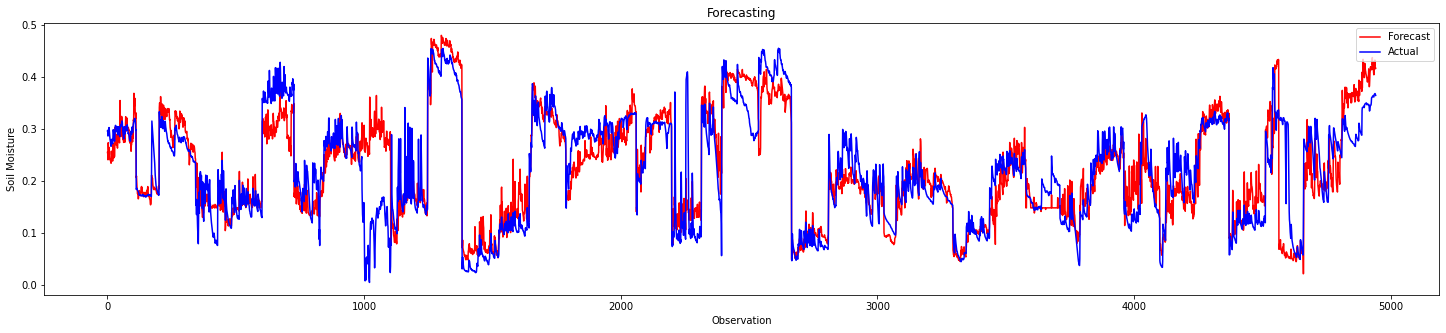

In [26]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/DNN_c5_20.png', dpi=400)
plt.show()

#Depth 50cm

In [27]:
raw50 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_50.csv')
df50 = raw50.copy()

df50 = df50.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df50['NDVI'])
replace_missing(df50['EVI'])
replace_missing(df50['LSTDay'])
replace_missing(df50['LSTNight'])

df50 = df50.dropna()
df50.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [28]:
df50['group'] = df50['Sand'].ne(df50['Sand'].shift()).cumsum()
df50 = df50.groupby('group')
dfs = []
for name, data in df50:
    dfs.append(data)

In [29]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [30]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [31]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

validation_data = (x_val, y_val)

In [32]:
opt_par = [0.009918516915338321, 4, 133, 'sigmoid']

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 133)               1862      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 133)               17822     
_________________________________________________________________
layer_dense_3 (Dense)        (None, 133)               17822     
_________________________________________________________________
layer_dense_4 (Dense)        (None, 133)               17822     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 134       
Total params: 55,462
Trainable params: 55,462
Non-trainable params: 0
_________________________________________________________________
Train on 36617 samples, validate on 4577 samples
Epoch 1/100
36617/36617 - 3s - loss: 0.0266 - mean_squared_error: 0

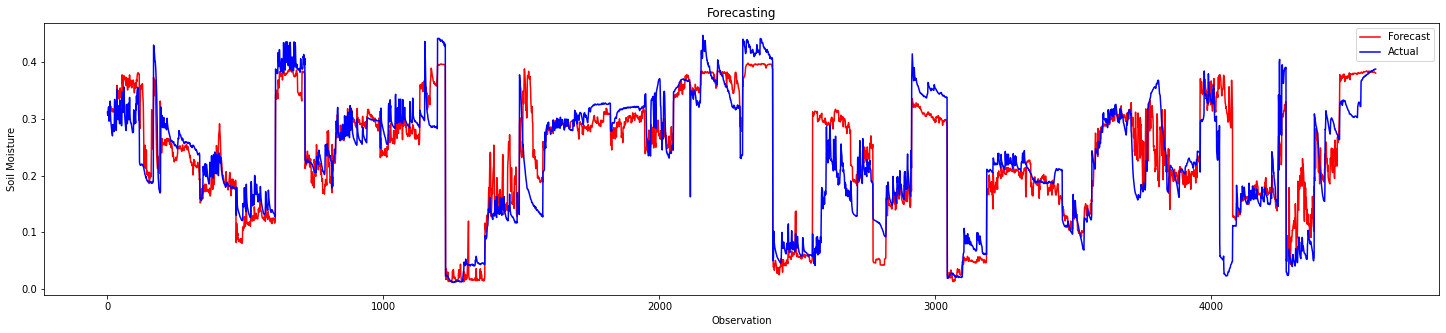

In [33]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/DNN_c5_50.png', dpi=400)
plt.show()

#Depth 100cm


In [34]:
raw100 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_100.csv')
df100 = raw100.copy()

df100 = df100.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df100['NDVI'])
replace_missing(df100['EVI'])
replace_missing(df100['LSTDay'])
replace_missing(df100['LSTNight'])

df100 = df100.dropna()
df100.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [35]:
df100['group'] = df100['Sand'].ne(df100['Sand'].shift()).cumsum()
df100 = df100.groupby('group')
dfs = []
for name, data in df100:
    dfs.append(data)

In [36]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [37]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [38]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

validation_data = (x_val, y_val)

In [39]:
opt_par = [0.009473503129600637, 2, 129, 'relu']

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 129)               1806      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 129)               16770     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 130       
Total params: 18,706
Trainable params: 18,706
Non-trainable params: 0
_________________________________________________________________
Train on 33984 samples, validate on 4246 samples
Epoch 1/100
33984/33984 - 3s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 2/100
33984/33984 - 2s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 3/100
33984/33984 - 2s - loss: 0.0021 - mean_squared_error: 0.0021 - val_lo

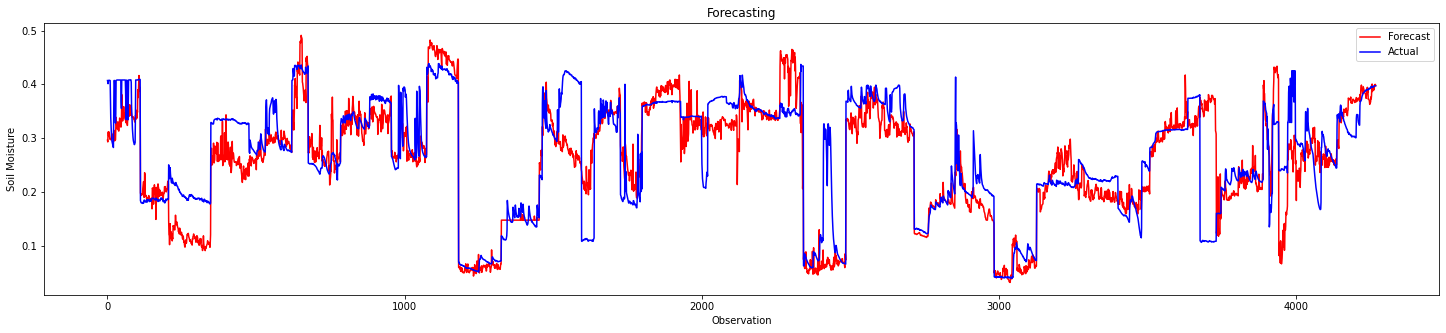

In [40]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/DNN_c5_100.png', dpi=400)
plt.show()